# Data Preparation

In [11]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from logistic import LogisticRegression, GradientDescentOptimizer

# generate random data points
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gradient Descent Experimentation

First lets performa a vanilla gradient descent with pdims = 2, a small α, and 𝛽 = 0. We would expect the loss to decrease monotonically. 

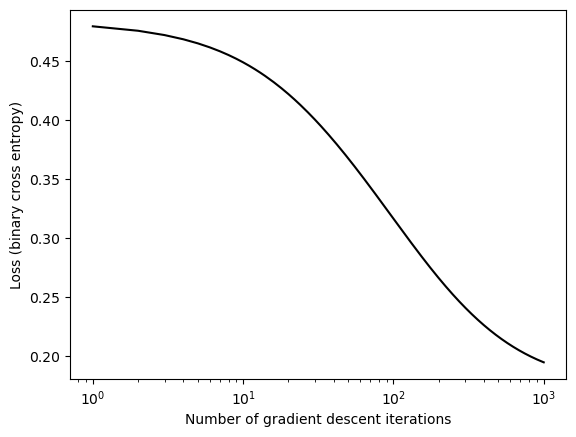

In [12]:
# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(1000):

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    # only this line actually changes the parameter value
    opt.step(X, y, alpha = 0.1, Beta = 0)

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

The implementation appears correct because the loss function decreases monotonically over iterations, which is expected in properly functioning gradient descent for logistic regression. The smooth decline in binary cross-entropy loss indicates that the model is learning effectively without divergence or oscillations. Additionally, the logarithmic x-axis confirms that the loss reduction is well-behaved over multiple orders of magnitude in iterations. These characteristics suggest that the weight updates are correctly applied and that the optimization process is progressing as intended. Now on the same data, implement gradient descent with a 𝛽 = .9 and compare the difference in plots.

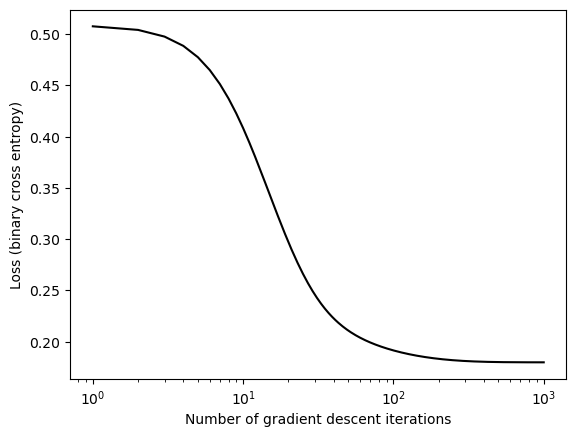

In [13]:
# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(1000):

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y)
    loss_vec.append(loss)

    # only this line actually changes the parameter value
    opt.step(X, y, alpha = 0.1, Beta = .9)

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

Comparing the gradient descent with momentum (𝛽>0) to the previous vanilla gradient descent (𝛽=0), we observe that the addition of momentum leads to a smoother and faster convergence. The loss decreases more rapidly in the early iterations, demonstrating how momentum helps accelerate learning by reducing oscillations and maintaining directional consistency. In contrast, the previous descent without momentum had a more gradual decline in loss. This confirms that momentum improves optimization efficiency, reaching a lower loss in fewer iterations while maintaining stability. Now, let's explore how the algorithim handles overfitting where pdims > n_points.

In [14]:
# generate random data points with pdims > n points
def classification_data2(n_points = 150, noise = 0.2, p_dims = 300):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# generate a training and test set with pdims > n points
X_train, y_train = classification_data2(noise = 0.5)
X_test, y_test = classification_data2(noise = .5)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

# training loop without keep track of loss
for _ in range(1000):

    # only this line actually changes the parameter value
    opt.step(X_train, y_train, alpha = 0.1, Beta = .9)

# calculate training accuracy
y_pred = LR.predict(X_train)
acc = (1.0*(y_pred == y_train)).mean().item()

print("The model has a training accuracy of: " + str(acc))

# calculate the testing accuracy
y_pred = LR.predict(X_test)
acc = (1.0*(y_pred == y_test)).mean().item()

print("The model has a testing accuracy of: " + str(acc))

The model has a training accuracy of: 1.0
The model has a testing accuracy of: 0.9399999976158142


The Wine Quality dataset from the UCI Machine Learning Repository consists of two datasets related to red and white Vinho Verde wines from Portugal. These datasets were originally compiled by researchers Paulo Cortez and colleagues at the University of Minho in collaboration with the Viticulture Commission of the Vinho Verde Region (CVRVV). Each dataset contains physicochemical measurements of wine samples—1,599 red wines and 4,898 white wines—alongside sensory quality scores rated by professional tasters. The goal is to model wine quality based on chemical properties, making the data suitable for both regression and classification tasks. The original study describing the dataset is “Modeling wine preferences by data mining from physicochemical properties” by Cortez et al., published in Decision Support Systems (2009).

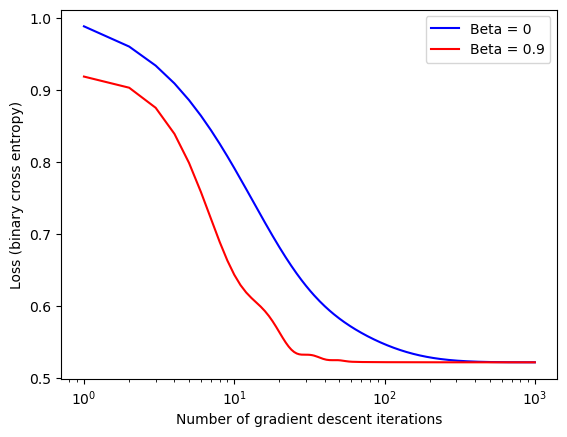

The loss of the model with Beta = 0 is: 0.49104881286621094
The loss of the model with Beta = .9 is: 0.49072471261024475
The accuracy of the model with Beta = 0 is: 0.7507692575454712
The accuracy of the model with Beta = .9 is: 0.7523077130317688


In [15]:
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import numpy as np
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features.to_numpy() 
y = wine_quality.data.targets.to_numpy()

# Convert quality scores to binary labels (1 for high, 0 for low)
y = (y > 5).astype(int)  # Vectorized operation

# Split into train (60%), val (20%), test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).squeeze()
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch. float32).squeeze()

# add a 1 to the end of each row
X_train = torch.cat((X_train, torch.ones((X_train.shape[0], 1))), 1)
X_test = torch.cat((X_test, torch.ones((X_test.shape[0], 1))), 1)


# perform a logistic regression on the data
# instantiate a model and an optimizer
LR1 = LogisticRegression()
LR2 = LogisticRegression() 
opt1 = GradientDescentOptimizer(LR1)
opt2 = GradientDescentOptimizer(LR2)

# for keeping track of loss values
loss1_vec = []
loss2_vec = []

for _ in range(1000):
    # Track loss values (convert tensors to scalars)
    loss1_vec.append(LR1.loss(X_train, y_train))
    loss2_vec.append(LR2.loss(X_train, y_train))

    # Perform optimization step
    opt1.step(X_train, y_train, alpha = 0.1, Beta = 0)
    opt2.step(X_train, y_train, alpha = 0.1, Beta = 0.9)

# Plot loss over iterations
plt.plot(range(1, len(loss1_vec) + 1), loss1_vec, color = "blue", label = "Beta = 0")
plt.plot(range(1, len(loss2_vec) + 1), loss2_vec, color = "red", label = "Beta = 0.9")
plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.show()

# Compute the Loss and Accuracy of the Model Against the Test Set
print("The loss of the model with Beta = 0 is: " + str(LR1.loss(X_test, y_test).item()))
print("The loss of the model with Beta = .9 is: " + str(LR2.loss(X_test, y_test).item()))

# calculate the models accuracies
y_pred1 = LR1.predict(X_test)
y_pred2 = LR2.predict(X_test)

acc1 = (1.0*(y_pred1 == y_test)).mean()
acc2 = (1.0*(y_pred2 == y_test)).mean()

print("The accuracy of the model with Beta = 0 is: " + str(acc1.item()))
print("The accuracy of the model with Beta = .9 is: " + str(acc2.item()))